In [1]:
import numpy as np
import cv2
import time
import sys
import tensorflow as tf

class YOLO_TF:
	fromfile = None
	tofile_img = 'test/output.jpg'
	tofile_txt = 'test/output.txt'
	imshow = True
	filewrite_img = False
	filewrite_txt = False
	disp_console = True
	weights_file = 'weights/YOLO_small.ckpt'
	alpha = 0.1
	threshold = 0.2
	iou_threshold = 0.5
	num_class = 20
	num_box = 2
	grid_size = 7
	classes =  ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train","tvmonitor"]

	w_img = 640
	h_img = 480

	def __init__(self,argvs = []):
		self.argv_parser(argvs)
		self.build_networks()
		if self.fromfile is not None: self.detect_from_file(self.fromfile)
	def argv_parser(self,argvs):
		for i in range(1,len(argvs),2):
			if argvs[i] == '-fromfile' : self.fromfile = argvs[i+1]
			if argvs[i] == '-tofile_img' : self.tofile_img = argvs[i+1] ; self.filewrite_img = True
			if argvs[i] == '-tofile_txt' : self.tofile_txt = argvs[i+1] ; self.filewrite_txt = True
			if argvs[i] == '-imshow' :
				if argvs[i+1] == '1' :self.imshow = True
				else : self.imshow = False
			if argvs[i] == '-disp_console' :
				if argvs[i+1] == '1' :self.disp_console = True
				else : self.disp_console = False
				
	def build_networks(self):
		if self.disp_console : print "Building YOLO_small graph..."
		self.x = tf.placeholder('float32',[None,448,448,3])
		self.conv_1 = self.conv_layer(1,self.x,64,7,2)
		self.pool_2 = self.pooling_layer(2,self.conv_1,2,2)
		self.conv_3 = self.conv_layer(3,self.pool_2,192,3,1)
		self.pool_4 = self.pooling_layer(4,self.conv_3,2,2)
		self.conv_5 = self.conv_layer(5,self.pool_4,128,1,1)
		self.conv_6 = self.conv_layer(6,self.conv_5,256,3,1)
		self.conv_7 = self.conv_layer(7,self.conv_6,256,1,1)
		self.conv_8 = self.conv_layer(8,self.conv_7,512,3,1)
		self.pool_9 = self.pooling_layer(9,self.conv_8,2,2)
		self.conv_10 = self.conv_layer(10,self.pool_9,256,1,1)
		self.conv_11 = self.conv_layer(11,self.conv_10,512,3,1)
		self.conv_12 = self.conv_layer(12,self.conv_11,256,1,1)
		self.conv_13 = self.conv_layer(13,self.conv_12,512,3,1)
		self.conv_14 = self.conv_layer(14,self.conv_13,256,1,1)
		self.conv_15 = self.conv_layer(15,self.conv_14,512,3,1)
		self.conv_16 = self.conv_layer(16,self.conv_15,256,1,1)
		self.conv_17 = self.conv_layer(17,self.conv_16,512,3,1)
		self.conv_18 = self.conv_layer(18,self.conv_17,512,1,1)
		self.conv_19 = self.conv_layer(19,self.conv_18,1024,3,1)
		self.pool_20 = self.pooling_layer(20,self.conv_19,2,2)
		self.conv_21 = self.conv_layer(21,self.pool_20,512,1,1)
		self.conv_22 = self.conv_layer(22,self.conv_21,1024,3,1)
		self.conv_23 = self.conv_layer(23,self.conv_22,512,1,1)
		self.conv_24 = self.conv_layer(24,self.conv_23,1024,3,1)
		self.conv_25 = self.conv_layer(25,self.conv_24,1024,3,1)
		self.conv_26 = self.conv_layer(26,self.conv_25,1024,3,2)
		self.conv_27 = self.conv_layer(27,self.conv_26,1024,3,1)
		self.conv_28 = self.conv_layer(28,self.conv_27,1024,3,1)
		self.fc_29 = self.fc_layer(29,self.conv_28,512,flat=True,linear=False)
		self.fc_30 = self.fc_layer(30,self.fc_29,4096,flat=False,linear=False)
		#skip dropout_31
		self.fc_32 = self.fc_layer(32,self.fc_30,1470,flat=False,linear=True)
		self.sess = tf.Session()
		self.sess.run(tf.initialize_all_variables())
		self.saver = tf.train.Saver()
		self.saver.restore(self.sess,self.weights_file)
		if self.disp_console : print "Loading complete!" + '\n'

	def conv_layer(self,idx,inputs,filters,size,stride):
		channels = inputs.get_shape()[3]
		weight = tf.Variable(tf.truncated_normal([size,size,int(channels),filters], stddev=0.1))
		biases = tf.Variable(tf.constant(0.1, shape=[filters]))

		pad_size = size//2
		pad_mat = np.array([[0,0],[pad_size,pad_size],[pad_size,pad_size],[0,0]])
		inputs_pad = tf.pad(inputs,pad_mat)

		conv = tf.nn.conv2d(inputs_pad, weight, strides=[1, stride, stride, 1], padding='VALID',name=str(idx)+'_conv')	
		conv_biased = tf.add(conv,biases,name=str(idx)+'_conv_biased')	
		if self.disp_console : print '    Layer  %d : Type = Conv, Size = %d * %d, Stride = %d, Filters = %d, Input channels = %d' % (idx,size,size,stride,filters,int(channels))
		return tf.maximum(self.alpha*conv_biased,conv_biased,name=str(idx)+'_leaky_relu')

	def pooling_layer(self,idx,inputs,size,stride):
		if self.disp_console : print '    Layer  %d : Type = Pool, Size = %d * %d, Stride = %d' % (idx,size,size,stride)
		return tf.nn.max_pool(inputs, ksize=[1, size, size, 1],strides=[1, stride, stride, 1], padding='SAME',name=str(idx)+'_pool')

	def fc_layer(self,idx,inputs,hiddens,flat = False,linear = False):
		input_shape = inputs.get_shape().as_list()		
		if flat:
			dim = input_shape[1]*input_shape[2]*input_shape[3]
			inputs_transposed = tf.transpose(inputs,(0,3,1,2))
			inputs_processed = tf.reshape(inputs_transposed, [-1,dim])
		else:
			dim = input_shape[1]
			inputs_processed = inputs
		weight = tf.Variable(tf.truncated_normal([dim,hiddens], stddev=0.1))
		biases = tf.Variable(tf.constant(0.1, shape=[hiddens]))	
		if self.disp_console : print '    Layer  %d : Type = Full, Hidden = %d, Input dimension = %d, Flat = %d, Activation = %d' % (idx,hiddens,int(dim),int(flat),1-int(linear))	
		if linear : return tf.add(tf.matmul(inputs_processed,weight),biases,name=str(idx)+'_fc')
		ip = tf.add(tf.matmul(inputs_processed,weight),biases)
		return tf.maximum(self.alpha*ip,ip,name=str(idx)+'_fc')

	def detect_from_cvmat(self,img):
		s = time.time()
		self.h_img,self.w_img,_ = img.shape
		img_resized = cv2.resize(img, (448, 448))
		img_RGB = cv2.cvtColor(img_resized,cv2.COLOR_BGR2RGB)
		img_resized_np = np.asarray( img_RGB )
		inputs = np.zeros((1,448,448,3),dtype='float32')
		inputs[0] = (img_resized_np/255.0)*2.0-1.0
		in_dict = {self.x: inputs}
		net_output = self.sess.run(self.fc_32,feed_dict=in_dict)
		self.result = self.interpret_output(net_output[0])
		self.show_results(img,self.result)
		strtime = str(time.time()-s)
		if self.disp_console : print 'Elapsed time : ' + strtime + ' secs' + '\n'

	def detect_from_file(self,filename):
		if self.disp_console : print 'Detect from ' + filename
		img = cv2.imread(filename)
		#img = misc.imread(filename)
		self.detect_from_cvmat(img)

	def detect_from_crop_sample(self):
		self.w_img = 640
		self.h_img = 420
		f = np.array(open('person_crop.txt','r').readlines(),dtype='float32')
		inputs = np.zeros((1,448,448,3),dtype='float32')
		for c in range(3):
			for y in range(448):
				for x in range(448):
					inputs[0,y,x,c] = f[c*448*448+y*448+x]

		in_dict = {self.x: inputs}
		net_output = self.sess.run(self.fc_32,feed_dict=in_dict)
		self.boxes, self.probs = self.interpret_output(net_output[0])
		img = cv2.imread('person.jpg')
		self.show_results(self.boxes,img)

	def interpret_output(self,output):
		probs = np.zeros((7,7,2,20))
		class_probs = np.reshape(output[0:980],(7,7,20))
		scales = np.reshape(output[980:1078],(7,7,2))
		boxes = np.reshape(output[1078:],(7,7,2,4))
		offset = np.transpose(np.reshape(np.array([np.arange(7)]*14),(2,7,7)),(1,2,0))

		boxes[:,:,:,0] += offset
		boxes[:,:,:,1] += np.transpose(offset,(1,0,2))
		boxes[:,:,:,0:2] = boxes[:,:,:,0:2] / 7.0
		boxes[:,:,:,2] = np.multiply(boxes[:,:,:,2],boxes[:,:,:,2])
		boxes[:,:,:,3] = np.multiply(boxes[:,:,:,3],boxes[:,:,:,3])
		
		boxes[:,:,:,0] *= self.w_img
		boxes[:,:,:,1] *= self.h_img
		boxes[:,:,:,2] *= self.w_img
		boxes[:,:,:,3] *= self.h_img

		for i in range(2):
			for j in range(20):
				probs[:,:,i,j] = np.multiply(class_probs[:,:,j],scales[:,:,i])

		filter_mat_probs = np.array(probs>=self.threshold,dtype='bool')
		filter_mat_boxes = np.nonzero(filter_mat_probs)
		boxes_filtered = boxes[filter_mat_boxes[0],filter_mat_boxes[1],filter_mat_boxes[2]]
		probs_filtered = probs[filter_mat_probs]
		classes_num_filtered = np.argmax(filter_mat_probs,axis=3)[filter_mat_boxes[0],filter_mat_boxes[1],filter_mat_boxes[2]] 

		argsort = np.array(np.argsort(probs_filtered))[::-1]
		boxes_filtered = boxes_filtered[argsort]
		probs_filtered = probs_filtered[argsort]
		classes_num_filtered = classes_num_filtered[argsort]
		
		for i in range(len(boxes_filtered)):
			if probs_filtered[i] == 0 : continue
			for j in range(i+1,len(boxes_filtered)):
				if self.iou(boxes_filtered[i],boxes_filtered[j]) > self.iou_threshold : 
					probs_filtered[j] = 0.0
		
		filter_iou = np.array(probs_filtered>0.0,dtype='bool')
		boxes_filtered = boxes_filtered[filter_iou]
		probs_filtered = probs_filtered[filter_iou]
		classes_num_filtered = classes_num_filtered[filter_iou]

		result = []
		for i in range(len(boxes_filtered)):
			result.append([self.classes[classes_num_filtered[i]],boxes_filtered[i][0],boxes_filtered[i][1],boxes_filtered[i][2],boxes_filtered[i][3],probs_filtered[i]])

		return result

	def show_results(self,img,results):
		img_cp = img.copy()
		if self.filewrite_txt :
			ftxt = open(self.tofile_txt,'w')
		for i in range(len(results)):
			x = int(results[i][1])
			y = int(results[i][2])
			w = int(results[i][3])//2
			h = int(results[i][4])//2
			if self.disp_console : print '    class : ' + results[i][0] + ' , [x,y,w,h]=[' + str(x) + ',' + str(y) + ',' + str(int(results[i][3])) + ',' + str(int(results[i][4]))+'], Confidence = ' + str(results[i][5])
			if self.filewrite_img or self.imshow:
				cv2.rectangle(img_cp,(x-w,y-h),(x+w,y+h),(0,255,0),2)
				cv2.rectangle(img_cp,(x-w,y-h-20),(x+w,y-h),(125,125,125),-1)
				cv2.putText(img_cp,results[i][0] + ' : %.2f' % results[i][5],(x-w+5,y-h-7),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
			if self.filewrite_txt :				
				ftxt.write(results[i][0] + ',' + str(x) + ',' + str(y) + ',' + str(w) + ',' + str(h)+',' + str(results[i][5]) + '\n')
		if self.filewrite_img : 
			if self.disp_console : print '    image file writed : ' + self.tofile_img
			cv2.imwrite(self.tofile_img,img_cp)			
		if self.imshow :
			cv2.imshow('YOLO_small detection',img_cp)
			cv2.waitKey(1)
		if self.filewrite_txt : 
			if self.disp_console : print '    txt file writed : ' + self.tofile_txt
			ftxt.close()

	def iou(self,box1,box2):
		tb = min(box1[0]+0.5*box1[2],box2[0]+0.5*box2[2])-max(box1[0]-0.5*box1[2],box2[0]-0.5*box2[2])
		lr = min(box1[1]+0.5*box1[3],box2[1]+0.5*box2[3])-max(box1[1]-0.5*box1[3],box2[1]-0.5*box2[3])
		if tb < 0 or lr < 0 : intersection = 0
		else : intersection =  tb*lr
		return intersection / (box1[2]*box1[3] + box2[2]*box2[3] - intersection)

	def training(self): #TODO add training function!
		return None



In [3]:
yolo = YOLO_TF()

Building YOLO_small graph...
    Layer  1 : Type = Conv, Size = 7 * 7, Stride = 2, Filters = 64, Input channels = 3
    Layer  2 : Type = Pool, Size = 2 * 2, Stride = 2
    Layer  3 : Type = Conv, Size = 3 * 3, Stride = 1, Filters = 192, Input channels = 64
    Layer  4 : Type = Pool, Size = 2 * 2, Stride = 2
    Layer  5 : Type = Conv, Size = 1 * 1, Stride = 1, Filters = 128, Input channels = 192
    Layer  6 : Type = Conv, Size = 3 * 3, Stride = 1, Filters = 256, Input channels = 128
    Layer  7 : Type = Conv, Size = 1 * 1, Stride = 1, Filters = 256, Input channels = 256
    Layer  8 : Type = Conv, Size = 3 * 3, Stride = 1, Filters = 512, Input channels = 256
    Layer  9 : Type = Pool, Size = 2 * 2, Stride = 2
    Layer  10 : Type = Conv, Size = 1 * 1, Stride = 1, Filters = 256, Input channels = 512
    Layer  11 : Type = Conv, Size = 3 * 3, Stride = 1, Filters = 512, Input channels = 256
    Layer  12 : Type = Conv, Size = 1 * 1, Stride = 1, Filters = 256, Input channels = 512
   

In [ ]:
yolo.detect_from_file('test/person.jpg')

Detect from test/person.jpg


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
%matplotlib inline

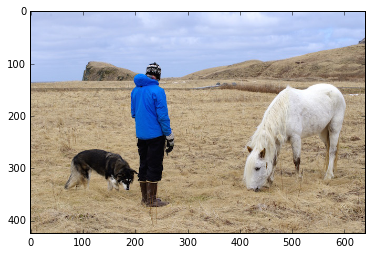

In [6]:
img = cv2.imread('test/person.jpg')
img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img_RGB)

In [2]:
cap = cv2.VideoCapture(0)

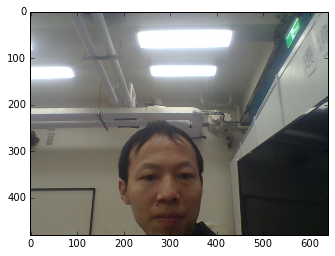

In [20]:
# while(True):
    # Capture frame-by-frame
ret, frame = cap.read()

    # Our operations on the frame come here
    # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Display the resulting frame
#     cv2.imshow('frame',frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
img_RGB = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(img_RGB)


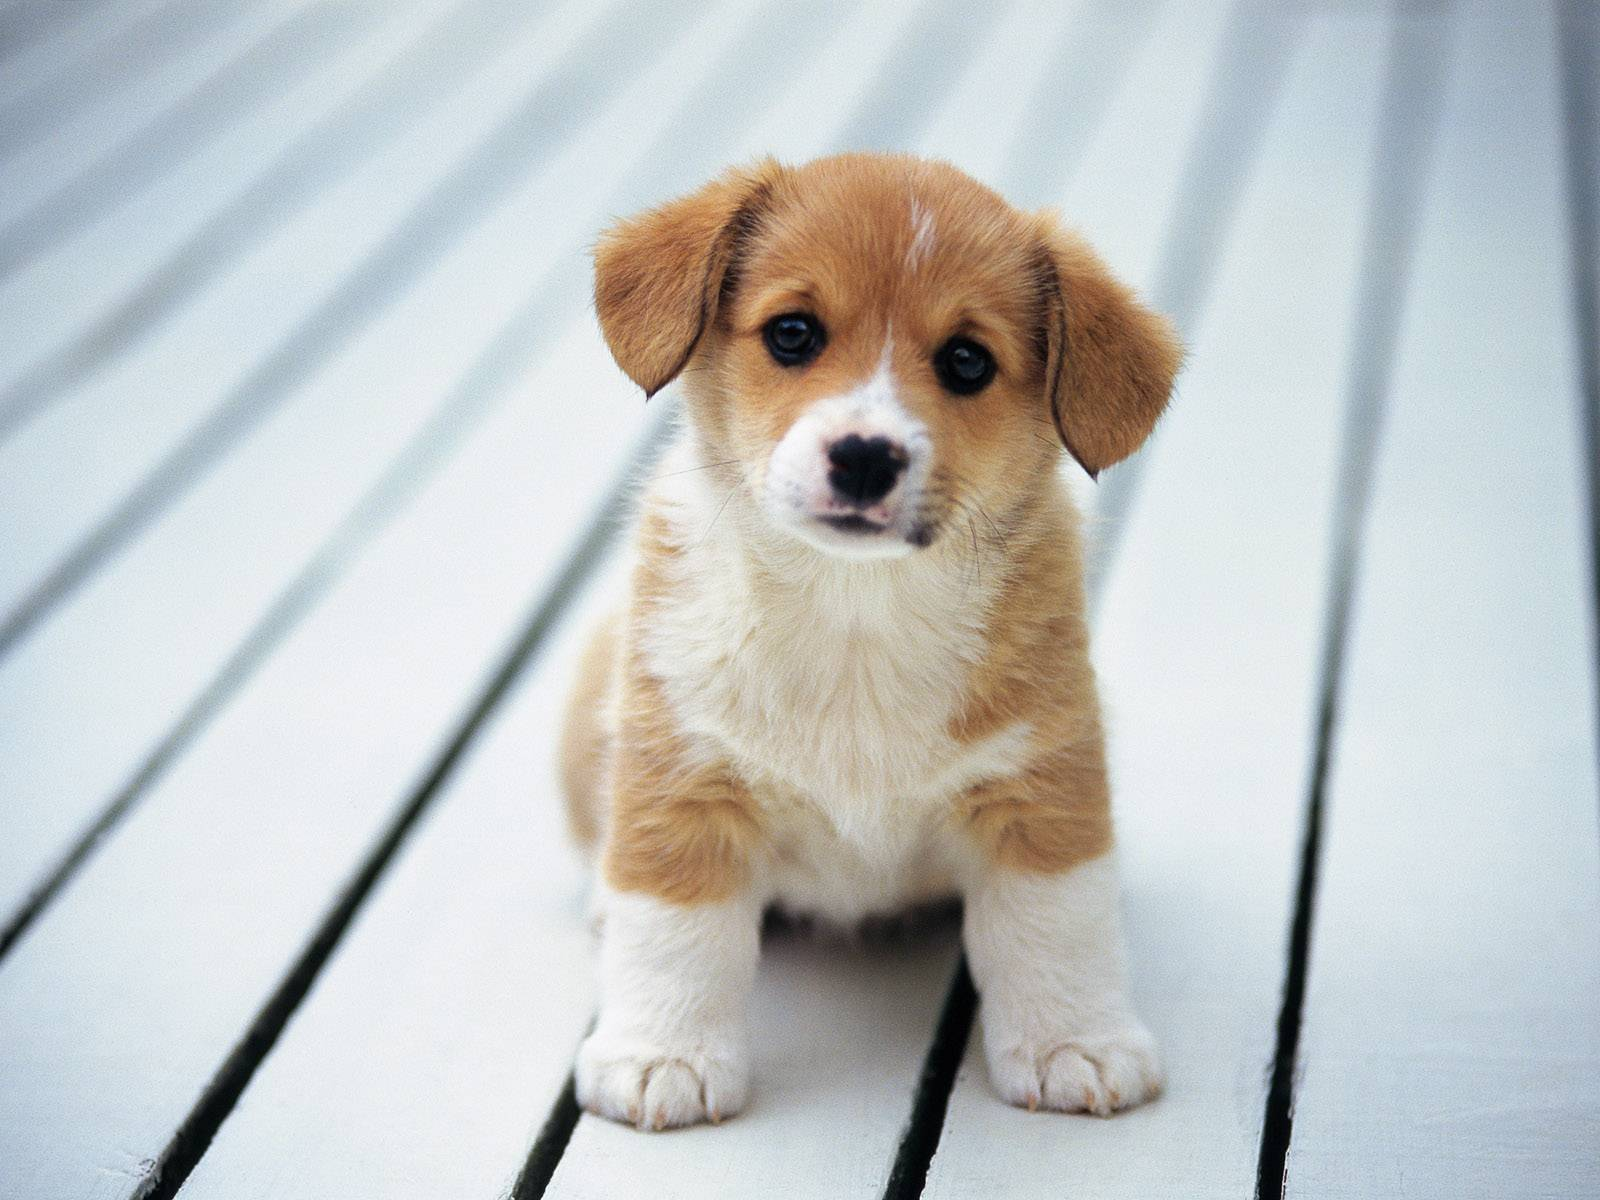

In [12]:
from IPython.display import Image
Image(filename='/home/dog2.jpg') 